In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [54]:
import numpy as np
import pandas as pd
import os
import random
import librosa as libr
import librosa.display as disp
from IPython.display import Audio
from scipy.io import wavfile

In [3]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchaudio.transforms import Resample
from torchsummary import summary
from torch.utils.data import SubsetRandomSampler,Subset,DataLoader
from torchmetrics.audio import ScaleInvariantSignalNoiseRatio
from torchmetrics.audio import pesq as PESQ

In [4]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA RTX A5000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [47]:
retrain = 1
save_per_epoch = 5
torch.manual_seed(0)

In [49]:
config = {
    'sample_rate':48000,
    'max_duration':4,
    'n_fft':1024,
    'hop_length':512,
    'n_mels':64,
    'batch_size':128,
    'learning_rate': 5e-5,
    'epochs':200,
    'val_split':0.9,
}

In [7]:
# !wget https://datashare.ed.ac.uk/bitstream/handle/10283/2791/clean_testset_wav.zip?sequence=1&isAllowed=y
# !wget https://datashare.ed.ac.uk/bitstream/handle/10283/2791/clean_trainset_28spk_wav.zip?sequence=2&isAllowed=y
# !wget https://datashare.ed.ac.uk/bitstream/handle/10283/2791/noisy_trainset_28spk_wav.zip?sequence=6&isAllowed=y
# !wget https://datashare.ed.ac.uk/bitstream/handle/10283/2791/noisy_testset_wav.zip?sequence=5&isAllowed=y

In [8]:
# !unzip "./data/noisy_trainset_28spk_wav.zip"
# !unzip "./data/clean_trainset_28spk_wav.zip"
# !unzip "./data/noisy_testset_wav.zip"
# !unzip "./data/clean_testset_wav.zip"

In [8]:
train_noisy_data_path = "./noisy_trainset_28spk_wav/"
train_clean_data_path = "./clean_trainset_28spk_wav/"
test_noisy_data_path = "./noisy_testset_wav/"
test_clean_data_path = "./clean_testset_wav/"

In [9]:
class AudioDataset(Dataset):
    def __init__(self,noisy_path,clean_path, transform=None, sample_rate=None,max_duration=None):

        #get file paths
        noisy_all_items = os.listdir(noisy_path)
        noisy_files = [item for item in noisy_all_items if os.path.isfile(os.path.join(noisy_path, item)) and item.lower().endswith('.wav')]
        noisy_file_paths = [os.path.join(noisy_path, file_name) for file_name in noisy_files]
        clean_file_paths = [os.path.join(clean_path, file_name) for file_name in noisy_files]

        #initialize variables
        self.noisy_data = noisy_file_paths
        self.clean_data = clean_file_paths
        self.transform = transform
        self.sample_rate = sample_rate
        self.max_duration = max_duration
        self.num_samples = sample_rate*max_duration

    def __len__(self):
        return len(self.noisy_data)

    def __getitem__(self, idx):
        noisy_waveform, sr = torchaudio.load(self.noisy_data[idx])
        noisy_waveform = torch.tensor(noisy_waveform.numpy().reshape(-1))
        if noisy_waveform.shape[0] < self.num_samples:
            num_missing_samples = self.num_samples - noisy_waveform.shape[0]
            noisy_waveform = F.pad(noisy_waveform, (0, num_missing_samples))
        noisy_waveform = torch.tensor(noisy_waveform[:self.num_samples])
        noisy_audio = noisy_waveform
        if self.transform:
            noisy_waveform = self.transform(noisy_waveform)


        clean_waveform, sr = torchaudio.load(self.clean_data[idx])
        clean_waveform = torch.tensor(clean_waveform.numpy().reshape(-1))
        if clean_waveform.shape[0] < self.num_samples:
            num_missing_samples = self.num_samples - clean_waveform.shape[0]
            clean_waveform = F.pad(torch.tensor(clean_waveform), (0, num_missing_samples))
        clean_waveform = torch.tensor(clean_waveform[:self.num_samples])
        clean_audio = clean_waveform
        if self.transform:
            clean_waveform = self.transform(clean_waveform)
        return noisy_waveform, clean_waveform, noisy_audio, clean_audio

In [10]:
def split_dataset(dataset, perc=0.9):
    dataset_indices = list(range(len(dataset)))
    random.shuffle(dataset_indices)
    train_indices = dataset_indices[:int(len(dataset_indices) * perc)]
    val_indices = dataset_indices[int(len(dataset_indices) * perc):]
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    return train_dataset,val_dataset

In [12]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=config['sample_rate'],
                                                      n_fft=config['n_fft'],
                                                      hop_length=config['hop_length'],
                                                      n_mels=config['n_mels'])

train_dataset = AudioDataset(noisy_path=train_noisy_data_path,
                       clean_path=train_clean_data_path,
                       sample_rate=config['sample_rate'],
                       max_duration=config['max_duration'],
                       transform=mel_spectrogram)
test_dataset = AudioDataset(noisy_path=test_noisy_data_path,
                       clean_path=test_clean_data_path,
                       sample_rate=config['sample_rate'],
                       max_duration=config['max_duration'],
                       transform=mel_spectrogram)

train_dataset, val_dataset = split_dataset(train_dataset,config['val_split'])

train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {config['batch_size']}")
print(f"Length of val dataloader: {len(val_dataloader)} batches of {config['batch_size']}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {config['batch_size']}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f2fcf71bbd0>, <torch.utils.data.dataloader.DataLoader object at 0x7f2fcf71bf10>)
Length of train dataloader: 82 batches of 128
Length of val dataloader: 10 batches of 128
Length of test dataloader: 7 batches of 128


In [13]:
class BaseUNetModel(nn.Module):
    def __init__(self):
        super(BaseUNetModel,self).__init__()
        
        self.down_conv_layer_1 = nn.Sequential(
            nn.Conv2d(1, 64 , kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
        )        
 
        self.down_conv_layer_2 = nn.Sequential(
            nn.Conv2d(64, 128 , kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            
        ) 
    
        self.down_conv_layer_3 = nn.Sequential(
            nn.Conv2d(128, 256 , kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            
        ) 
        
        self.down_conv_layer_4 = nn.Sequential(
            nn.Conv2d(256, 256 , kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),   
        )

        self.down_conv_layer_5 = nn.Sequential(
            nn.Conv2d(256, 256 , kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),   
        ) 

        self.down_conv_layer_6 = nn.Sequential(
            nn.Conv2d(256, 256 , kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),   
        ) 
        
        self.up_conv_layer_1 = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=(2,3), stride=2, padding=0),
            nn.InstanceNorm2d(256),
            nn.ReLU(), 
            nn.Dropout(0.5), 
        )
        
        self.up_conv_layer_2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=(2,3), stride=2, padding=0),
            nn.InstanceNorm2d(256),
            nn.ReLU(), 
            nn.Dropout(0.5), 
        )
        
        self.up_conv_layer_3 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=(2,3), stride=2, padding=0),
            nn.InstanceNorm2d(256),
            nn.ReLU(), 
            nn.Dropout(0.5), 
        )

        self.up_conv_layer_4 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, kernel_size=(4), stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(), 
            nn.Dropout(0.5), 
        )

        self.up_conv_layer_5 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, kernel_size=(4), stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(), 
        )
                
        self.upsample_layer = nn.Upsample(scale_factor=2)
        self.zero_pad = nn.ZeroPad2d((1, 0, 1, 0))
        self.conv_layer_final = nn.Conv2d(128, 1, kernel_size=4, padding=1)

    def forward(self,x):
        # print("x", x.shape)
        enc1 = self.down_conv_layer_1(x)
        # print("enc1", enc1.shape)
        enc2 = self.down_conv_layer_2(enc1) 
        # print("enc2", enc2.shape)
        enc3 = self.down_conv_layer_3(enc2) 
        # print("enc3", enc3.shape)
        enc4 = self.down_conv_layer_4(enc3)
        # print("enc4", enc4.shape)
        enc5 = self.down_conv_layer_5(enc4)
        # print("enc5", enc5.shape)
        enc6 = self.down_conv_layer_6(enc5)
        # print("enc6", enc6.shape)

        dec1 = self.up_conv_layer_1(enc6)
        # print("dec1", dec1.shape)
        dec15 = torch.cat((dec1, enc5), 1)
        # print("dec15", dec15.shape)

        dec2 = self.up_conv_layer_2(dec15)
        # print("dec2", dec2.shape)
        dec24 = torch.cat((dec2, enc4), 1)
        # print("dec24", dec24.shape)

        dec3 = self.up_conv_layer_3(dec24)
        # print("dec3", dec3.shape)
        dec33 = torch.cat((dec3, enc3), 1)
        # print("dec33", dec33.shape)

        dec4 = self.up_conv_layer_4(dec33)
        # print("dec4", dec4.shape)
        dec42 = torch.cat((dec4, enc2), 1)
        # print("dec42", dec42.shape)

        dec5 = self.up_conv_layer_5(dec42)
        # print("dec5", dec5.shape)
        dec51 = torch.cat((dec5, enc1), 1)
        # print("dec51", dec51.shape)

        final = self.upsample_layer(dec51)
        # print("up", final.shape)
        final = self.zero_pad(final)
        # print("zero", final.shape)
        final = self.conv_layer_final(final)
        # print("final", final.shape)
        return final

In [14]:
model = BaseUNetModel()
model = model.cuda()

rand_inp = torch.randn(64,1,64,376).cuda()
rand_out = model(rand_inp)
print(rand_out.shape)

torch.Size([64, 1, 64, 376])


In [15]:
summary(model,input_size=(1, 64, 376), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [64, 64, 32, 188]           1,088
         LeakyReLU-2          [64, 64, 32, 188]               0
            Conv2d-3          [64, 128, 16, 94]         131,200
    InstanceNorm2d-4          [64, 128, 16, 94]               0
         LeakyReLU-5          [64, 128, 16, 94]               0
            Conv2d-6           [64, 256, 8, 47]         524,544
    InstanceNorm2d-7           [64, 256, 8, 47]               0
         LeakyReLU-8           [64, 256, 8, 47]               0
            Conv2d-9           [64, 256, 4, 23]       1,048,832
   InstanceNorm2d-10           [64, 256, 4, 23]               0
        LeakyReLU-11           [64, 256, 4, 23]               0
          Dropout-12           [64, 256, 4, 23]               0
           Conv2d-13           [64, 256, 2, 11]       1,048,832
   InstanceNorm2d-14           [64, 256

In [16]:
# ssnr_fs = 22050
# ssnr = ScaleInvariantSignalNoiseRatio().cuda()

# def get_ssnr(preds, clean):
#     print(preds.shape, clean.shape)
#     inv_mel = preds.cpu().data.numpy()
#     S = libr.feature.inverse.mel_to_stft(inv_mel, sr=ssnr_fs)#config['sample_rate'])
#     preds_audio = libr.griffinlim(S)
#     ssnr_score = ssnr(preds_audio,clean).item()
#     return ssnr_score

In [17]:
# get_pesq_fs = 16000
# pesq = PESQ.PerceptualEvaluationSpeechQuality(get_pesq_fs,'nb').cuda()

# def get_pesq(preds, clean):
#     inv_mel = preds.cpu().data.numpy()
#     S = libr.feature.inverse.mel_to_stft(inv_mel, sr=ssnr_fs)#config['sample_rate'])
#     preds_audio = libr.griffinlim(S)
#     resampler = Resample(orig_freq=config['sample_rate'], new_freq=get_pesq_fs).cuda()
#     preds_resample = resampler(preds_audio)
#     clean_resample = resampler(clean)
#     pesq_score = pesq(preds_resample,clean_resample).item()
#     return pesq_score

In [16]:
def sample_preprop(transform):
    sample_path = './noisy_testset_wav/p232_001.wav'
    num_samples = config['max_duration']*config['sample_rate']

    noisy_sample, sr = torchaudio.load(sample_path)
    noisy_waveform = torch.tensor(noisy_sample.numpy().reshape(-1))
    if noisy_waveform.shape[0] < num_samples:
        num_missing_samples = num_samples - noisy_waveform.shape[0]
        noisy_waveform = F.pad(noisy_waveform, (0, num_missing_samples))
    noisy_waveform = torch.tensor(noisy_waveform[:num_samples])
    if transform:
        noisy_waveform = transform(noisy_waveform)
    noisy_waveform = noisy_waveform.unsqueeze(dim=0).unsqueeze(dim=0)
    return noisy_waveform
sample_noisy_waveform = sample_preprop(mel_spectrogram)
print(sample_noisy_waveform.shape)

torch.Size([1, 1, 64, 376])


In [17]:
def save_inter_ouput(model,transform):
    noisy_waveform = sample_noisy_waveform.cuda()
    model = model.cuda()
    
    model.eval()
    pred = model(noisy_waveform).squeeze(1).squeeze(0)
    mel = pred.cpu().data.numpy()
    S = libr.feature.inverse.mel_to_stft(mel, sr=config['sample_rate'])
    pred_audio = libr.griffinlim(S)
    return pred_audio

In [18]:
train_len = len(train_dataloader)
val_len = len(val_dataloader)
test_len = len(test_dataloader)
print(train_len,val_len, test_len)

82 10 7


In [50]:
model = BaseUNetModel()
model = model.cuda()

if retrain:
  PATH = './denoise_model_400'
  model.load_state_dict(torch.load(PATH))
  print("loaded pretrained model..")
  
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

train_losses,val_losses = [],[]
train_scores_ssnr,val_scores_ssnr = [],[]
train_scores_pesq,val_scores_pesq = [],[]
num_epochs = config['epochs']
intermediate_ouputs = {}

print("starting training..")
for epoch in range(1,num_epochs+1):

  model.train()
  epoch_loss,epoch_ssnr,epoch_pesq = 0.0,0.0,0.0

  for i, data in enumerate(train_dataloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      X, y, noise , clean = data
      X = X.unsqueeze(1)
      X, y  = Variable(X.cuda()), Variable(y.cuda())
      # noise, clean = Variable(noise.cuda()),Variable(clean.cuda())

      optimizer.zero_grad()
      preds = model(X).squeeze(1)
      preds = preds.cuda()
      
      loss = criterion(preds.float(), y.float())
      # ssnr_score = get_ssnr(preds, clean)
      # pesq_score = get_pesq(preds, clean)

      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      
      # epoch_ssnr += ssnr_score
      # epoch_pesq += pesq_score

  train_losses.append(epoch_loss)
  # train_scores_ssnr.append(epoch_ssnr)
  # train_scores_pesq.append(epoch_pesq)
  #print(f'Training: Epoch {epoch}/{num_epochs} Loss: {epoch_loss:.4f} SSNR: {epoch_ssnr:.4f} PESQ: {epoch_pesq:.4f}')
  print(f'Training: Epoch {epoch}/{num_epochs} MSE Loss: {epoch_loss:.4f} MSE Lossperbatch: {epoch_loss/train_len:.4f}')
  if((epoch == 1) or (epoch%50 == 0)):
    intermediate_ouputs[str(epoch)] = save_inter_ouput(model,mel_spectrogram)
      
  #Validation
  model.eval()
  val_loss,val_ssnr,val_pesq = 0.0,0.0,0.0
  with torch.no_grad():
    for i, data in enumerate(val_dataloader, 0):
      X_val, y_val, noise_val,clean_val = data
      X_val = X_val.unsqueeze(1)
      X_val, y_val = Variable(X_val.cuda()), Variable(y_val.cuda())
      # noise_val, clean_val = Variable(noise_val.cuda()),Variable(clean_val.cuda())

      preds_val = model(X_val).squeeze(1).cuda()
      val_loss += criterion(preds_val.float(), y_val.float()).item()
      # val_ssnr += get_ssnr(preds_val, clean)
      # val_pesq += get_pesq(preds_val, clean)

  val_losses.append(val_loss)
  # val_scores_ssnr.append(val_ssnr)
  # val_scores_pesq.append(val_pesq)
  # print(f'Validation: Epoch {epoch}/{num_epochs} Loss: {val_loss:.4f} SSNR: {val_ssnr:.4f} PESQ: {epoch_pesq:.4f}')
  print(f'Validation: MSE Loss: {val_loss:.4f} MSE Lossperbatch: {val_loss/val_len:.4f}')
  if (epoch%save_per_epoch == 0):
    PATH = './denoise_model_600'
    torch.save(model.state_dict(), PATH)
  print("=======================================")

loaded pretrained model..
starting training..
Training: Epoch 1/200 MSE Loss: 25338.8722 MSE Lossperbatch: 309.0106
Validation: MSE Loss: 1918.0109 MSE Lossperbatch: 191.8011
Training: Epoch 2/200 MSE Loss: 25171.6953 MSE Lossperbatch: 306.9719
Validation: MSE Loss: 1916.4256 MSE Lossperbatch: 191.6426
Training: Epoch 3/200 MSE Loss: 25038.7730 MSE Lossperbatch: 305.3509
Validation: MSE Loss: 1908.3977 MSE Lossperbatch: 190.8398
Training: Epoch 4/200 MSE Loss: 24962.3258 MSE Lossperbatch: 304.4186
Validation: MSE Loss: 1895.8713 MSE Lossperbatch: 189.5871
Training: Epoch 5/200 MSE Loss: 24870.1662 MSE Lossperbatch: 303.2947
Validation: MSE Loss: 1905.3908 MSE Lossperbatch: 190.5391
Training: Epoch 6/200 MSE Loss: 24895.4915 MSE Lossperbatch: 303.6036
Validation: MSE Loss: 1905.3484 MSE Lossperbatch: 190.5348
Training: Epoch 7/200 MSE Loss: 24829.6753 MSE Lossperbatch: 302.8009
Validation: MSE Loss: 1886.6022 MSE Lossperbatch: 188.6602
Training: Epoch 8/200 MSE Loss: 24745.2701 MSE Loss

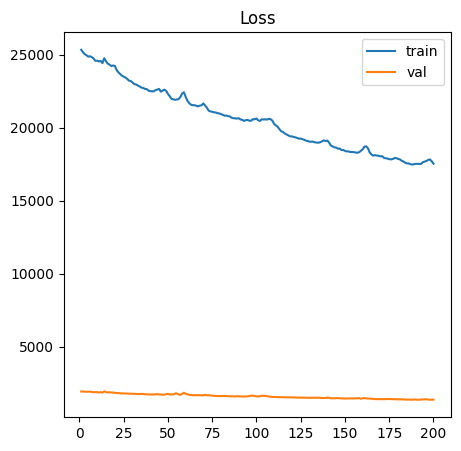

In [51]:
plt.figure(figsize=(5, 5))

# plt.subplot(1, 3, 1)
x = [i for i in range(1,len(train_losses)+1)]
plt.plot(x,train_losses, label='train')
plt.plot(x,val_losses, label='val')
plt.title('Loss')
plt.savefig('mel_loss_400.png')
plt.legend()

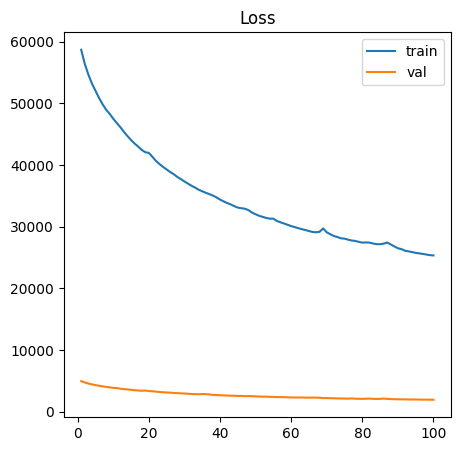

In [46]:
plt.figure(figsize=(5, 5))

# plt.subplot(1, 3, 1)
x = [i for i in range(1,len(train_losses)+1)]
plt.plot(x,train_losses, label='train')
plt.plot(x,val_losses, label='val')
plt.title('Loss')
plt.savefig('mel_loss_400.png')
plt.legend()

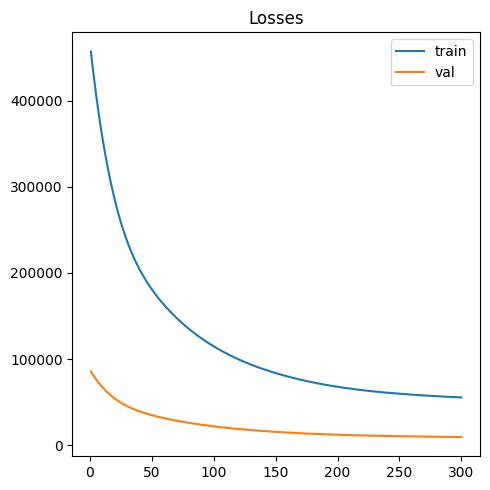

In [ ]:
plt.figure(figsize=(5, 5))

# plt.subplot(1, 3, 1)
x = [i for i in range(1,len(train_losses)+1)]
plt.plot(x,train_losses, label='train')
plt.plot(x,val_losses, label='val')
plt.title('Loss')
plt.legend()

# plt.subplot(1, 3, 2)
# plt.plot(torch.tensor(train_scores_ssnr), label='train')
# plt.plot(torch.tensor(val_scores_ssnr), label='val')
# plt.title('SSNR Scores')
# plt.legend()

# plt.subplot(1, 3, 3)
# plt.plot(train_scores_pesq, label='train')
# plt.plot(val_scores_pesq, label='test')
# plt.title('PESQ Scores')
# plt.legend()

plt.tight_layout()
plt.show()

In [23]:
model.eval()
test_loss,test_ssnr,test_pesq = 0.0,0.0,0.0
with torch.no_grad():
  for i, data in enumerate(test_dataloader, 0):
    X, y, noise, clean = data
    X = X.unsqueeze(1)
    X, y = Variable(X.cuda()), Variable(y.cuda())

    preds = model(X).squeeze(1)
    preds = preds.cuda()

    loss = criterion(preds.float().squeeze(1), y.float())
    # ssnr_score = get_ssnr(preds, clean)
    # pesq_score = get_pesq(preds, clean)

    test_loss += loss.item()
    # test_ssnr += ssnr_score
    # test_pesq += pesq_score

print(f'Test: Loss: {test_loss:.4f} Test: Lossperbatch: {test_loss/test_len:.4f} ')#SSNR: {test_ssnr:.4f} PESQ: {test_pesq:.4f}')

Test: Loss: 1458.9481 Test: Lossperbatch: 208.4212 


In [52]:
for k in intermediate_ouputs.keys():
    print(k, intermediate_ouputs[k].shape)

1 (192000,)
50 (192000,)
100 (192000,)
150 (192000,)
200 (192000,)


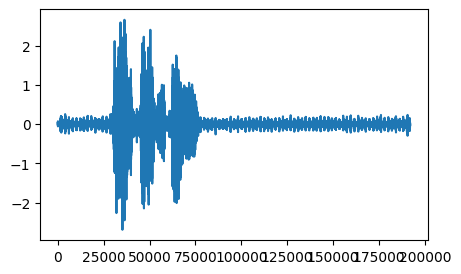

In [59]:
k = '1'
plt.figure(figsize=(5,3))
plt.plot(intermediate_ouputs[k])
Audio(intermediate_ouputs[k],rate=48000)

filtered_sample_path = 'pred_400.wav'
wavfile.write(filtered_sample_path, 48000, intermediate_ouputs[k])


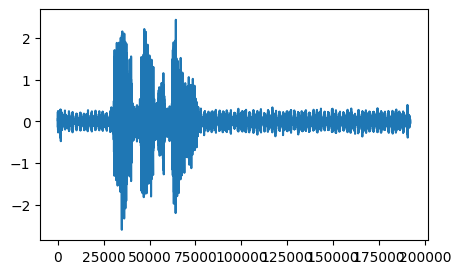

In [58]:
k = '50'
plt.figure(figsize=(5,3))
plt.plot(intermediate_ouputs[k])

filtered_sample_path = './pred_450.wav'
wavfile.write(filtered_sample_path, 48000, intermediate_ouputs[k])
Audio(intermediate_ouputs[k],rate=48000)



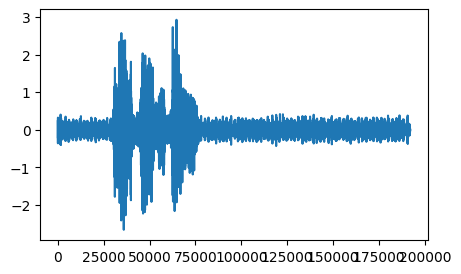

In [60]:
k = '100'
plt.figure(figsize=(5,3))
plt.plot(intermediate_ouputs[k])
Audio(intermediate_ouputs[k],rate=48000)

filtered_sample_path = 'pred_500.wav'
wavfile.write(filtered_sample_path, 48000, intermediate_ouputs[k])


In [61]:
def get_sample_predicted_ouputs(id=0):
  test_audio,test_outputs, noisy_audio, clean_audio = next(iter(test_dataloader))
  outputs = model(test_audio.unsqueeze(dim=1).cuda()).squeeze(1)
  mel = outputs[id].cpu().data.numpy()
  S = libr.feature.inverse.mel_to_stft(mel, sr=config['sample_rate'])
  pred_audio = libr.griffinlim(S)
  print(noisy_audio[id].shape,clean_audio[id].shape, pred_audio.shape)
  print(test_audio[id].shape,test_outputs[id].shape, outputs[id].shape)
  return [noisy_audio[id],clean_audio[id], pred_audio],[test_audio[id],test_outputs[id],outputs[id]]

In [62]:
audio_outputs,mel_outputs = get_sample_predicted_ouputs(id=5)

torch.Size([192000]) torch.Size([192000]) (192000,)
torch.Size([64, 376]) torch.Size([64, 376]) torch.Size([64, 376])


In [63]:
Audio(audio_outputs[0], rate=48000)

In [64]:
Audio(audio_outputs[1], rate=48000)

In [65]:
Audio(audio_outputs[2], rate=48000)

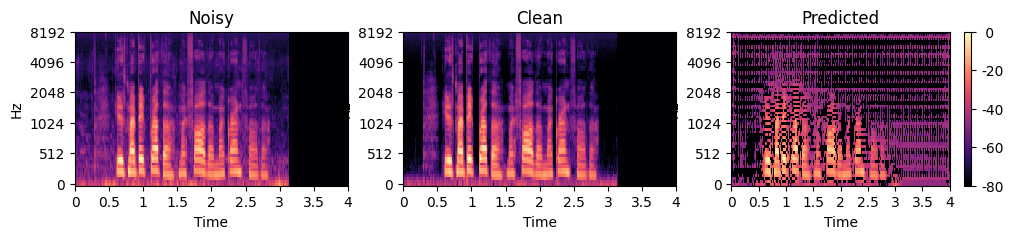

In [67]:
S1,S2,S3 = mel_outputs
S3 = S3.cpu().detach().numpy()
plt.figure(figsize=(12, 2))

plt.subplot(1, 3, 1)
S_dB = libr.power_to_db(S1, ref=np.max)
img = libr.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=config['sample_rate'],
                         fmax=8000)
plt.title('Noisy')

plt.subplot(1, 3, 2)
S_dB = libr.power_to_db(S2, ref=np.max)
img = libr.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=config['sample_rate'],
                         fmax=8000)
plt.title('Clean')

plt.subplot(1, 3, 3)
S_dB = libr.power_to_db(S3, ref=np.max)
img = libr.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=config['sample_rate'],
                         fmax=8000)
plt.title('Predicted')
plt.colorbar(format='%2.0f')
plt.savefig('mel_pred_600.png')
plt.show()


In [ ]:
# S = mel_outputs[2].cpu().detach().numpy()

# fig, ax = plt.subplots()
# S_dB = libr.power_to_db(S, ref=np.max)
# img = libr.display.specshow(S_dB, x_axis='time',
#                          y_axis='mel', sr=config['sample_rate'],
#                          fmax=8000, ax=ax)
# fig.colorbar(img, ax=ax, format='%+2.0f dB')
# ax.set(title='Mel-frequency spectrogram')
# # plt.savefig('pred.png')

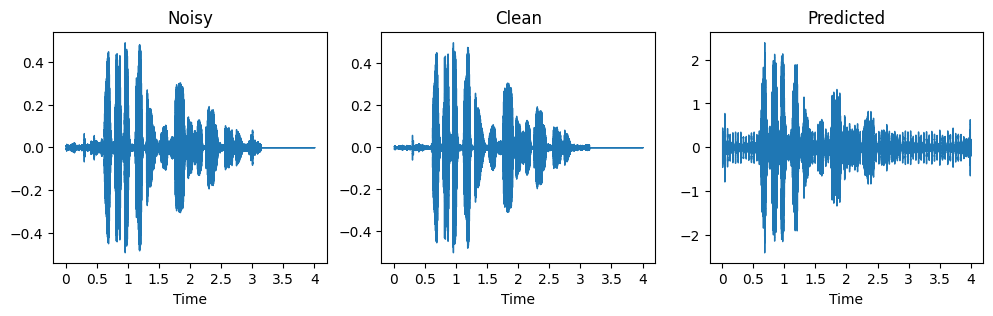

In [68]:
S1,S2,S3 = audio_outputs[0].numpy(),audio_outputs[1].numpy(),audio_outputs[2]
plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
disp.waveshow(S1,sr=config['sample_rate'])
plt.title('Noisy')

plt.subplot(1, 3, 2)
disp.waveshow(S2,sr=config['sample_rate'])
plt.title('Clean')

plt.subplot(1, 3, 3)
disp.waveshow(S3,sr=config['sample_rate'])
plt.title('Predicted')
plt.savefig('sig_pred_600.png')
plt.show()

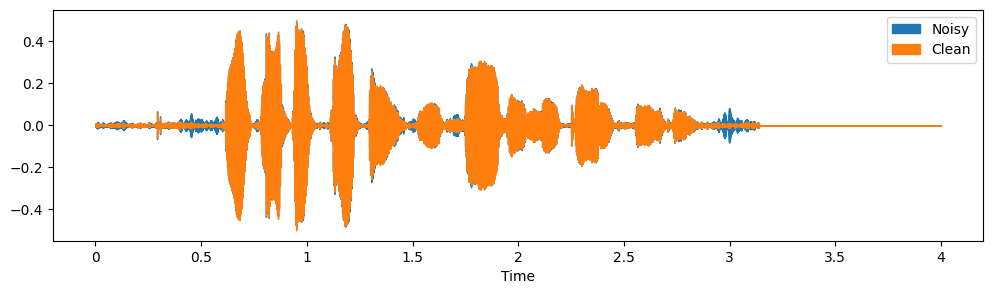

In [43]:
plt.figure(figsize=(12, 3))
disp.waveshow(S1,sr=config['sample_rate'],label='Noisy')
disp.waveshow(S2,sr=config['sample_rate'],label='Clean')
plt.legend()
plt.show()

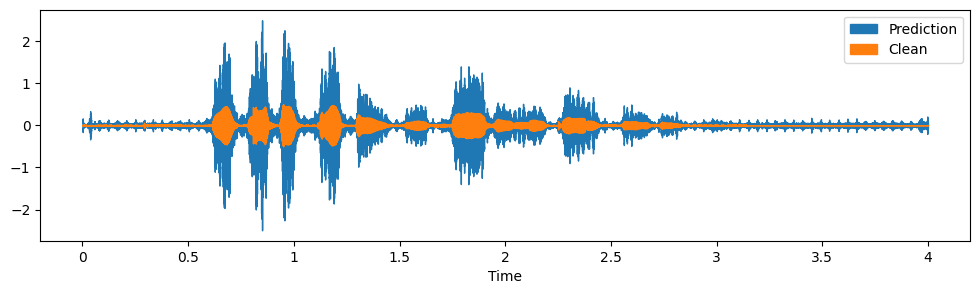

In [44]:
plt.figure(figsize=(12, 3))
disp.waveshow(S3,sr=config['sample_rate'],label='Prediction')
disp.waveshow(S2,sr=config['sample_rate'],label='Clean')
plt.legend()
plt.show()

In [ ]:
# use torch metrics
# use a baseline model network
# use torch summary tensor board, callback

In [69]:
PATH = './denoise_model_'+str(num_epochs)
torch.save(model.state_dict(), PATH)